In [1]:
from glob import glob
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import jaccard_score as iou_score
import segmentation_models_pytorch as smp
from dataclasses import dataclass
from collections import defaultdict
from torchvision.transforms import GaussianBlur
from utils import read_img

c:\Users\Viktor\Documents\IT\ReservoirRockAnalysis\src\NeuralNetwork\.venv\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.3' (you have '2.0.2'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [33]:
BATCH_SIZE = 4
SIZE = 1536
EPOCHS = 20
N_CHANNELS = 3
N_CLASSES = 6
encoder = 'efficientnet-b0'
dataset = 'imagenet'
aux_params=dict(
    pooling='avg',
    dropout=0.5,
    activation=None,
    classes=N_CLASSES
)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_str = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [35]:
blur = GaussianBlur(3, sigma=(0.01, 1.0))

In [36]:
def transform_train():
    transforms = [
        # A.SafeRotate(p=0.4),
        A.RandomCrop(SIZE, SIZE, p=1),
        # A.HorizontalFlip(p=0.5),
        # A.Transpose(p=0.5),
        # A.ColorJitter(brightness=0.33,
        #               contrast=0.19,
        #               saturation=0.19,
        #               hue=(-0.05, 0.095),
        #               p=1),
    ]
    return A.Compose(transforms)


def transform_valid():
    transforms = [
        A.RandomCrop(SIZE+1, SIZE+1, p=1),
        A.Resize(SIZE, SIZE, p=1),
    ]
    return A.Compose(transforms)


def to_tensor():
    transforms = [
        ToTensorV2(p=1)
    ]
    return A.Compose(transforms)

In [37]:
from segmentation_models_pytorch.encoders import get_preprocessing_fn

class PoreDataset(Dataset):
    def __init__(self, df, transforms):
        super().__init__()
        self.df = df
        self.transforms = transforms
        self.to_tensor = to_tensor()
        self.preprocess_input = get_preprocessing_fn(encoder, pretrained='imagenet')

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):

        image = read_img(self.df.loc[index, 'image'])
        mask = read_img(self.df.loc[index, 'mask'], rgb=False)

        transformed = self.transforms(image=image, mask=mask)
        image, mask = transformed['image'], transformed['mask']

        transformed = self.to_tensor(image=image, mask=mask)
        image, mask = transformed['image'], transformed['mask']
        image = blur(image)
        image = torch.reshape(image, (SIZE, SIZE, 3))
        image = self.preprocess_input(image)
        image = torch.reshape(image, (3, SIZE, SIZE))
        return image, mask

In [38]:
def get_name(image):
    image_name = image.split('/')[-1]
    return image_name[:-4]

In [39]:
np.random.seed(42)

images = (
    glob(r"C:\Users\Viktor\Documents\IT\ReservoirRockAnalysis\data\Images\Sihor\images\*")
    +
    glob(r"C:\Users\Viktor\Documents\IT\ReservoirRockAnalysis\data\Images\Surhar\images\*")
)

masks = (
    glob(r"C:\Users\Viktor\Documents\IT\ReservoirRockAnalysis\data\Images\Sihor\masks\*")
    +
    glob(r"C:\Users\Viktor\Documents\IT\ReservoirRockAnalysis\data\Images\Surhar\masks\*")
)


images = sorted(list(images))[2:3]
masks = sorted(list(masks))[2:3]

print('images count: ', len(images))
print('masks count: ', len(masks))

assert  (length := len(images)) == len(masks)
is_valid = np.random.choice([False, True], length, p=[0.8, 0.2])
df = pd.DataFrame({'image': images, 'mask': masks, 'is_valid': is_valid})

# df.to_csv('/content/drive/MyDrive/pore segmentation/data.csv', sep=' ')

train_df = df[~df['is_valid']]
# valid_df = df[df['is_valid']]
valid_df = train_df.copy()
train_df.index, valid_df.index = np.arange(len(train_df)), np.arange(len(valid_df))

images count:  1
masks count:  1


In [40]:
train_df = pd.concat([train_df for _ in range(BATCH_SIZE)])
train_df.index = np.arange(BATCH_SIZE)
train_df

image  \
0  C:\Users\Viktor\Documents\IT\ReservoirRockAnal...   
1  C:\Users\Viktor\Documents\IT\ReservoirRockAnal...   
2  C:\Users\Viktor\Documents\IT\ReservoirRockAnal...   
3  C:\Users\Viktor\Documents\IT\ReservoirRockAnal...   

                                                mask  is_valid  
0  C:\Users\Viktor\Documents\IT\ReservoirRockAnal...     False  
1  C:\Users\Viktor\Documents\IT\ReservoirRockAnal...     False  
2  C:\Users\Viktor\Documents\IT\ReservoirRockAnal...     False  
3  C:\Users\Viktor\Documents\IT\ReservoirRockAnal...     False

In [41]:
valid_df

image  \
0  C:\Users\Viktor\Documents\IT\ReservoirRockAnal...   

                                                mask  is_valid  
0  C:\Users\Viktor\Documents\IT\ReservoirRockAnal...     False

In [42]:
train_datasets = PoreDataset(train_df, transforms=transform_train())
valid_datasets = PoreDataset(valid_df, transforms=transform_valid())

In [43]:
x, y = train_datasets[0]
x.shape, y.shape

(torch.Size([3, 1536, 1536]), torch.Size([1536, 1536]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..2.6399999999999997].


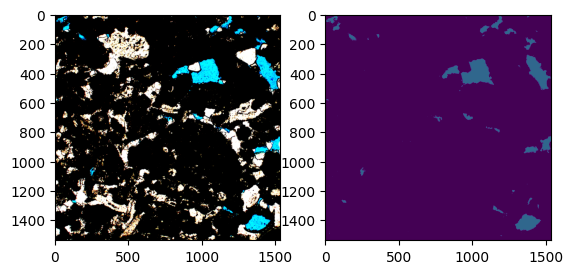

In [44]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(x.permute(1, 2, 0).cpu().numpy());
axs[1].imshow(y.cpu().numpy());

In [45]:
train_loader = DataLoader(
    train_datasets,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

valid_loader = DataLoader(
    valid_datasets,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [46]:
if __name__ == '__main__':
    xb, yb = next(iter(train_loader))
xb.shape, yb.shape, xb.dtype, yb.dtype

(torch.Size([4, 3, 1536, 1536]),
 torch.Size([4, 1536, 1536]),
 torch.float64,
 torch.uint8)

In [47]:
scaler = torch.amp.GradScaler(device_str)


class Learner():

    def __init__(self, model, train_loader, valid_loader, loss_fn, optimizer, train_info):
        self.model = model
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_info = train_info
        self.best_macro_iou = 0

    def calc_grad(self, xb, yb):
        with torch.amp.autocast(device_str):
            outputs = model(xb)
            losses = [loss_fn(out, yb) for out in outputs]
            loss = sum(losses)
        scaler.scale(loss).backward()
        return loss


    def calc_loss(self, xb, yb):
        preds = self.model(xb)[0].float()
        loss = self.loss_fn(preds, yb)
        return loss


    def train_epoch(self):

        epoch_loss = list()

        for xb, yb in tqdm(self.train_loader):

            xb = xb.cuda(non_blocking=True).float()
            yb = yb.cuda(non_blocking=True).to(torch.int64)

            self.optimizer.zero_grad()

            loss = self.calc_grad(xb, yb)
            scaler.step(self.optimizer)
            scaler.update()
            epoch_loss.append(loss.item())

        return np.round(np.array(epoch_loss).mean(), 6)

    @staticmethod
    def create_dict(loss, iou_micro, iou_macro, iou_classes):
        return {
                'loss': np.round(np.array(loss).mean(), 6),
                'iou_micro': np.round(np.array(iou_micro).mean(), 6),
                'iou_macro': np.round(np.array(iou_macro).mean(), 6),
                'iou_classes_0': np.round(np.array(iou_classes[0]).mean(), 6),
                'iou_classes_1': np.round(np.array(iou_classes[1]).mean(), 6),
                'iou_classes_2': np.round(np.array(iou_classes[2]).mean(), 6),
                # 'iou_classes_3': np.round(np.array(iou_classes[3]).mean(), 6),
                }


    def validate_epoch(self):

        iou_micro = list()
        iou_classes = defaultdict(list)
        iou_macro = list()
        loss = list()

        with torch.no_grad():
            for xb, yb in tqdm(valid_loader):

                xb = xb.to(device).float()
                yb = yb.to(device).to(torch.int64)
                loss.append(self.calc_loss(xb, yb).item())

                prds = model(xb)[0]
                prds = prds.argmax(axis=1)

                labels = yb.cpu().numpy().reshape(-1)
                targets = prds.cpu().numpy().reshape(-1)

                iou_micro.append(iou_score(labels, targets, average='micro', zero_division=0))

                iou_sum = 0

                for class_num in range(N_CLASSES):

                    class_labels = np.where(labels==class_num, 1, 0)
                    class_targets = np.where(targets==class_num, 1, 0)

                    iou = iou_score(class_labels, class_targets, average='binary', zero_division=0)
                    iou_classes[class_num].append(iou)
                    iou_sum += iou

                iou_macro.append(iou_sum/N_CLASSES)

        return self.create_dict(loss, iou_micro, iou_macro, iou_classes)


    def validate_n_epochs(self, n):

        iou_micro = list()
        iou_classes = defaultdict(list)
        iou_macro = list()
        loss = list()

        for _ in range(n):
            valid = self.validate_epoch()
            loss.append(valid['loss'])
            iou_micro.append(valid['iou_micro'])
            iou_macro.append(valid['iou_macro'])
            iou_classes[0].append(valid['iou_classes_0'])
            iou_classes[1].append(valid['iou_classes_1'])
            iou_classes[2].append(valid['iou_classes_2'])

        return self.create_dict(loss, iou_micro, iou_macro, iou_classes)


    def find_lr(self, init_value, final_value, beta):
        num = len(self.train_loader)-1
        mult = (final_value / init_value) ** (1/num)
        lr = init_value
        optimizer.param_groups[0]['lr'] = lr
        avg_loss = 0.
        best_loss = 0.
        batch_num = 0
        losses = []
        log_lrs = []
        for data in tqdm(self.train_loader):

            batch_num += 1

            inputs,labels = data
            inputs, labels = inputs.to(device).float(), labels.to(device).to(torch.int64)
            self.optimizer.zero_grad()
            outputs = self.model(inputs)[0]
            loss = self.loss_fn(outputs, labels)

            avg_loss = beta * avg_loss + (1-beta) * loss.item()
            smoothed_loss = avg_loss / (1 - beta**batch_num)

            if batch_num > 1 and smoothed_loss > 4 * best_loss:
                return log_lrs, losses

            if smoothed_loss < best_loss or batch_num==1:
                best_loss = smoothed_loss

            losses.append(smoothed_loss)
            log_lrs.append(lr)

            loss.backward()
            optimizer.step()

            lr *= mult
            optimizer.param_groups[0]['lr'] = lr

        return log_lrs, losses


    def plot_lr_finding(self, init_value=1e-8, final_value=1e1, beta = 0.98):
        log_lrs, losses = self.find_lr(init_value, final_value, beta)
        plt.plot(log_lrs, losses)
        plt.grid(True)
        plt.xscale('log')


    def train_model(self, EPOCHS):

        for i in range(EPOCHS):

            print(f'epoch: {i+1}/{EPOCHS}')
            print(f'lr:', self.optimizer.param_groups[0]['lr'])

            print('training model')
            self.model.train(True)
            loss = self.train_epoch()
            print('train_loss: ', loss)
            self.model.eval()
            print('validating model')
            valid = self.validate_epoch()

            print('valid_loss: ', valid['loss'])
            print('valid_iou_micro: ', valid['iou_micro'])
            print('valid_iou_macro: ', valid['iou_macro'])
            print('valid_iou_class_0: ', valid['iou_classes_0'])
            print('valid_iou_class_1: ', valid['iou_classes_1'])
            print('valid_iou_class_2: ', valid['iou_classes_2'])
            # print('valid_iou_class_3: ', valid['iou_classes_3'])

            self.train_info.epochs.append(i+1)
            self.train_info.train_loss.append(loss)
            self.train_info.valid_loss.append(valid['loss'])
            self.train_info.valid_iou_micro.append(valid['iou_micro'])
            self.train_info.valid_iou_macro.append(valid['iou_macro'])
            self.train_info.valid_iou_class_0.append(valid['iou_classes_0'])
            self.train_info.valid_iou_class_1.append(valid['iou_classes_1'])
            self.train_info.valid_iou_class_2.append(valid['iou_classes_2'])
            # self.train_info.valid_iou_class_3.append(valid['iou_classes_3'])

            if valid['iou_macro'] > self.best_macro_iou:
                
                self.best_macro_iou = valid['iou_macro']

            print()


    def plot_learning_info(self):
        fig, axs = plt.subplots(7, 1, figsize=(7, 30))
        axs[0].plot(self.train_info.epochs, self.train_info.train_loss);
        axs[0].set_title('Train loss')

        axs[1].plot(self.train_info.epochs, self.train_info.valid_loss);
        axs[1].set_title('Valid loss')

        axs[2].plot(self.train_info.epochs, self.train_info.valid_iou_micro);
        axs[2].set_title('Valid micro IoU')

        axs[3].plot(self.train_info.epochs, self.train_info.valid_iou_macro);
        axs[3].set_title('Valid macro IoU')

        axs[4].plot(self.train_info.epochs, self.train_info.valid_iou_class_0);
        axs[4].set_title('Valid class 0 IoU')

        axs[5].plot(self.train_info.epochs, self.train_info.valid_iou_class_1);
        axs[5].set_title('Valid class 1 IoU')

        axs[6].plot(self.train_info.epochs, self.train_info.valid_iou_class_2);
        axs[6].set_title('Valid class 2 IoU')

        # axs[7].plot(self.train_info.epochs, self.train_info.valid_iou_class_3);
        # axs[7].set_title('Valid class 3 IoU')

In [48]:
from segmentation_models_pytorch.losses import DiceLoss, FocalLoss

In [49]:
class CombinedLoss(torch.nn.Module):
    def __init__(self, dice_weight=0.2, focal_weight=0.8):
        super(CombinedLoss, self).__init__()
        self.dice_loss = DiceLoss('multiclass', from_logits=True)
        self.focal_loss = FocalLoss('multiclass', gamma=4)
        self.dice_weight = dice_weight
        self.focal_weight = focal_weight
    
    def forward(self, outputs, targets):
        dice_loss = self.dice_loss(outputs, targets)
        focal_loss = self.focal_loss(outputs, targets)
        return self.dice_weight * dice_loss + self.focal_weight * focal_loss

In [50]:
# model = smp.Unet(
#     encoder_name=encoder,
#     encoder_weights=dataset,
#     in_channels=N_CHANNELS,
#     classes=N_CLASSES,
#     aux_params=aux_params
#     ).to(device)

from models import HrSegNetB64

model = HrSegNetB64(num_classes=N_CLASSES, in_channels=N_CHANNELS).to(device)

# loss_fn = torch.nn.functional.cross_entropy
# loss_fn = DiceLoss(
#     'multiclass',
#     from_logits=True,
#     # alpha=0.7,
#     # beta=0.3
# )

loss_fn = CombinedLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)

@dataclass
class train_info():
    train_loss =  list()
    valid_loss = list()
    valid_iou_micro = list()
    valid_iou_macro = list()
    valid_iou_class_0 = list()
    valid_iou_class_1 = list()
    valid_iou_class_2 = list()
    valid_iou_class_3 = list()
    epochs = list()

learner = Learner(model, train_loader, valid_loader,
                  loss_fn, optimizer, train_info)
model

HrSegNetB64(
  (stage1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (stage2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (seg1): SegBlock(
    (h_conv1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (h_conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (h_conv3): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1):

In [51]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [52]:
# learner.plot_lr_finding(init_value=1e-9, final_value=10)

In [53]:
def get_color(clls):
    if clls == 0:
        return [0, 0, 0]
    elif clls == 1:
        return [0, 255, 0]
    elif clls == 2:
        return [255, 0, 255]
    elif clls == 3:
        return [255, 255, 0]
    elif clls == 4:
        return [255, 0, 0]
    elif clls == 5:
        return [0, 255, 255]
    else:
        return [255, 255, 255]

def get_image_mask(mask):
    s = mask.shape
    return np.array([get_color(pixel) for row in mask for pixel in row]).reshape(s + (3,))

In [54]:
learner.train_model(300)

epoch: 1/300
lr: 0.001
training model


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss:  1.195483
validating model


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


valid_loss:  0.33085
valid_iou_micro:  0.0
valid_iou_macro:  0.0
valid_iou_class_0:  0.0
valid_iou_class_1:  0.0
valid_iou_class_2:  0.0

epoch: 2/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


train_loss:  1.177955
validating model


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


valid_loss:  0.331604
valid_iou_micro:  0.0
valid_iou_macro:  0.0
valid_iou_class_0:  0.0
valid_iou_class_1:  0.0
valid_iou_class_2:  0.0

epoch: 3/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


train_loss:  1.158512
validating model


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


valid_loss:  0.297493
valid_iou_micro:  0.0
valid_iou_macro:  0.0
valid_iou_class_0:  0.0
valid_iou_class_1:  0.0
valid_iou_class_2:  0.0

epoch: 4/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


train_loss:  1.146113
validating model


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


valid_loss:  0.297206
valid_iou_micro:  0.0
valid_iou_macro:  0.0
valid_iou_class_0:  0.0
valid_iou_class_1:  0.0
valid_iou_class_2:  0.0

epoch: 5/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


train_loss:  1.12125
validating model


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


valid_loss:  0.297205
valid_iou_micro:  0.0
valid_iou_macro:  0.0
valid_iou_class_0:  0.0
valid_iou_class_1:  0.0
valid_iou_class_2:  0.0

epoch: 6/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


train_loss:  1.10263
validating model


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


valid_loss:  0.330352
valid_iou_micro:  0.0
valid_iou_macro:  0.0
valid_iou_class_0:  0.0
valid_iou_class_1:  0.0
valid_iou_class_2:  0.0

epoch: 7/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


train_loss:  1.078983
validating model


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


valid_loss:  0.329056
valid_iou_micro:  0.0
valid_iou_macro:  0.0
valid_iou_class_0:  0.0
valid_iou_class_1:  0.0
valid_iou_class_2:  0.0

epoch: 8/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


train_loss:  1.061521
validating model


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


valid_loss:  0.294961
valid_iou_micro:  0.0
valid_iou_macro:  0.0
valid_iou_class_0:  0.0
valid_iou_class_1:  0.0
valid_iou_class_2:  0.0

epoch: 9/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


train_loss:  1.042302
validating model


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


valid_loss:  0.328574
valid_iou_micro:  0.0
valid_iou_macro:  0.0
valid_iou_class_0:  0.0
valid_iou_class_1:  0.0
valid_iou_class_2:  0.0

epoch: 10/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


train_loss:  1.023707
validating model


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


valid_loss:  0.294361
valid_iou_micro:  0.0
valid_iou_macro:  0.0
valid_iou_class_0:  0.0
valid_iou_class_1:  0.0
valid_iou_class_2:  0.0

epoch: 11/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


train_loss:  1.003011
validating model


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


valid_loss:  0.293796
valid_iou_micro:  4.4e-05
valid_iou_macro:  1.5e-05
valid_iou_class_0:  8.8e-05
valid_iou_class_1:  0.0
valid_iou_class_2:  0.0

epoch: 12/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


train_loss:  0.886682
validating model


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


valid_loss:  0.291963
valid_iou_micro:  0.015495
valid_iou_macro:  0.005292
valid_iou_class_0:  0.031751
valid_iou_class_1:  0.0
valid_iou_class_2:  0.0

epoch: 13/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


train_loss:  0.968334
validating model


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


valid_loss:  0.325622
valid_iou_micro:  0.067974
valid_iou_macro:  0.021252
valid_iou_class_0:  0.127513
valid_iou_class_1:  0.0
valid_iou_class_2:  0.0

epoch: 14/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


train_loss:  0.952283
validating model


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


valid_loss:  0.323976
valid_iou_micro:  0.158708
valid_iou_macro:  0.046256
valid_iou_class_0:  0.277536
valid_iou_class_1:  0.0
valid_iou_class_2:  0.0

epoch: 15/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


train_loss:  0.933955
validating model


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


valid_loss:  0.323221
valid_iou_micro:  0.303991
valid_iou_macro:  0.07779
valid_iou_class_0:  0.466737
valid_iou_class_1:  0.0
valid_iou_class_2:  0.0

epoch: 16/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


train_loss:  0.919053
validating model


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


valid_loss:  0.287575
valid_iou_micro:  0.419595
valid_iou_macro:  0.099793
valid_iou_class_0:  0.598757
valid_iou_class_1:  0.0
valid_iou_class_2:  0.0

epoch: 17/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


train_loss:  0.90341
validating model


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


valid_loss:  0.286452
valid_iou_micro:  0.546364
valid_iou_macro:  0.118172
valid_iou_class_0:  0.709033
valid_iou_class_1:  0.0
valid_iou_class_2:  0.0

epoch: 18/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


train_loss:  0.899055
validating model


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


valid_loss:  0.284334
valid_iou_micro:  0.602953
valid_iou_macro:  0.126438
valid_iou_class_0:  0.758629
valid_iou_class_1:  0.0
valid_iou_class_2:  0.0

epoch: 19/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


train_loss:  0.873476
validating model


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


valid_loss:  0.283083
valid_iou_micro:  0.696248
valid_iou_macro:  0.137031
valid_iou_class_0:  0.822184
valid_iou_class_1:  0.0
valid_iou_class_2:  0.0

epoch: 20/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


train_loss:  0.861235
validating model


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


valid_loss:  0.281111
valid_iou_micro:  0.689561
valid_iou_macro:  0.136822
valid_iou_class_0:  0.820933
valid_iou_class_1:  0.0
valid_iou_class_2:  0.0

epoch: 21/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


train_loss:  0.848
validating model


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


valid_loss:  0.313367
valid_iou_micro:  0.756736
valid_iou_macro:  0.143747
valid_iou_class_0:  0.86248
valid_iou_class_1:  0.0
valid_iou_class_2:  0.0

epoch: 22/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


train_loss:  0.735097
validating model


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


valid_loss:  0.27824
valid_iou_micro:  0.734745
valid_iou_macro:  0.141598
valid_iou_class_0:  0.849588
valid_iou_class_1:  0.0
valid_iou_class_2:  0.0

epoch: 23/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


train_loss:  0.822949
validating model


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


valid_loss:  0.277131
valid_iou_micro:  0.80223
valid_iou_macro:  0.148487
valid_iou_class_0:  0.890925
valid_iou_class_1:  0.0
valid_iou_class_2:  0.0

epoch: 24/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


train_loss:  0.837785
validating model


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


valid_loss:  0.308918
valid_iou_micro:  0.809935
valid_iou_macro:  0.149247
valid_iou_class_0:  0.895481
valid_iou_class_1:  0.0
valid_iou_class_2:  0.0

epoch: 25/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


train_loss:  0.801752
validating model


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


valid_loss:  0.273769
valid_iou_micro:  0.771701
valid_iou_macro:  0.145628
valid_iou_class_0:  0.873768
valid_iou_class_1:  0.0
valid_iou_class_2:  0.0

epoch: 26/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


train_loss:  0.691004
validating model


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


valid_loss:  0.271849
valid_iou_micro:  0.795681
valid_iou_macro:  0.148188
valid_iou_class_0:  0.888986
valid_iou_class_1:  0.00014
valid_iou_class_2:  0.0

epoch: 27/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


train_loss:  0.790258
validating model


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


valid_loss:  0.271913
valid_iou_micro:  0.824669
valid_iou_macro:  0.15085
valid_iou_class_0:  0.905101
valid_iou_class_1:  0.0
valid_iou_class_2:  0.0

epoch: 28/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


train_loss:  0.768666
validating model


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


valid_loss:  0.266909
valid_iou_micro:  0.813861
valid_iou_macro:  0.150623
valid_iou_class_0:  0.902231
valid_iou_class_1:  0.001506
valid_iou_class_2:  0.0

epoch: 29/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


train_loss:  0.661865
validating model


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


valid_loss:  0.26818
valid_iou_micro:  0.861607
valid_iou_macro:  0.154356
valid_iou_class_0:  0.926137
valid_iou_class_1:  0.0
valid_iou_class_2:  0.0

epoch: 30/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


train_loss:  0.754697
validating model


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


valid_loss:  0.293715
valid_iou_micro:  0.873804
valid_iou_macro:  0.158013
valid_iou_class_0:  0.934683
valid_iou_class_1:  0.013396
valid_iou_class_2:  0.0

epoch: 31/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


train_loss:  0.743484
validating model


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


valid_loss:  0.288996
valid_iou_micro:  0.898323
valid_iou_macro:  0.162063
valid_iou_class_0:  0.948045
valid_iou_class_1:  0.023921
valid_iou_class_2:  0.000415

epoch: 32/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


train_loss:  0.735311
validating model


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


valid_loss:  0.28845
valid_iou_micro:  0.874318
valid_iou_macro:  0.171642
valid_iou_class_0:  0.935778
valid_iou_class_1:  0.09392
valid_iou_class_2:  0.000153

epoch: 33/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


train_loss:  0.726906
validating model


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


valid_loss:  0.260123
valid_iou_micro:  0.876204
valid_iou_macro:  0.156108
valid_iou_class_0:  0.934711
valid_iou_class_1:  0.001936
valid_iou_class_2:  0.0

epoch: 34/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


train_loss:  0.72164
validating model


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


valid_loss:  0.256719
valid_iou_micro:  0.868885
valid_iou_macro:  0.178659
valid_iou_class_0:  0.931519
valid_iou_class_1:  0.139676
valid_iou_class_2:  0.0

epoch: 35/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


train_loss:  0.712129
validating model


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


valid_loss:  0.281168
valid_iou_micro:  0.91455
valid_iou_macro:  0.193441
valid_iou_class_0:  0.956415
valid_iou_class_1:  0.202485
valid_iou_class_2:  0.000407

epoch: 36/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


train_loss:  0.717766
validating model


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


valid_loss:  0.250981
valid_iou_micro:  0.875319
valid_iou_macro:  0.194263
valid_iou_class_0:  0.935148
valid_iou_class_1:  0.228698
valid_iou_class_2:  0.0

epoch: 37/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


train_loss:  0.696358
validating model


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


valid_loss:  0.281108
valid_iou_micro:  0.879382
valid_iou_macro:  0.220441
valid_iou_class_0:  0.936837
valid_iou_class_1:  0.382827
valid_iou_class_2:  6.7e-05

epoch: 38/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


train_loss:  0.689128
validating model


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


valid_loss:  0.243412
valid_iou_micro:  0.869632
valid_iou_macro:  0.20251
valid_iou_class_0:  0.931963
valid_iou_class_1:  0.279242
valid_iou_class_2:  0.0

epoch: 39/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


train_loss:  0.693361
validating model


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


valid_loss:  0.276733
valid_iou_micro:  0.926953
valid_iou_macro:  0.160735
valid_iou_class_0:  0.962194
valid_iou_class_1:  0.002183
valid_iou_class_2:  3.5e-05

epoch: 40/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


train_loss:  0.680651
validating model


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


valid_loss:  0.234892
valid_iou_micro:  0.892949
valid_iou_macro:  0.217279
valid_iou_class_0:  0.945082
valid_iou_class_1:  0.355599
valid_iou_class_2:  0.0

epoch: 41/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


train_loss:  0.576324
validating model


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


valid_loss:  0.226052
valid_iou_micro:  0.902944
valid_iou_macro:  0.221194
valid_iou_class_0:  0.950558
valid_iou_class_1:  0.372715
valid_iou_class_2:  0.0

epoch: 42/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


train_loss:  0.562284
validating model


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


valid_loss:  0.265734
valid_iou_micro:  0.921488
valid_iou_macro:  0.2255
valid_iou_class_0:  0.960012
valid_iou_class_1:  0.391182
valid_iou_class_2:  0.000759

epoch: 43/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


train_loss:  0.665996
validating model


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


valid_loss:  0.26137
valid_iou_micro:  0.952497
valid_iou_macro:  0.165809
valid_iou_class_0:  0.975775
valid_iou_class_1:  0.016001
valid_iou_class_2:  0.000889

epoch: 44/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


train_loss:  0.557106
validating model


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


valid_loss:  0.223262
valid_iou_micro:  0.89933
valid_iou_macro:  0.220201
valid_iou_class_0:  0.947734
valid_iou_class_1:  0.3711
valid_iou_class_2:  0.0

epoch: 45/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


train_loss:  0.550387
validating model


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


valid_loss:  0.259628
valid_iou_micro:  0.952954
valid_iou_macro:  0.162879
valid_iou_class_0:  0.975966
valid_iou_class_1:  0.001187
valid_iou_class_2:  0.000119

epoch: 46/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


train_loss:  0.644668
validating model


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


valid_loss:  0.214001
valid_iou_micro:  0.912248
valid_iou_macro:  0.229175
valid_iou_class_0:  0.954567
valid_iou_class_1:  0.415649
valid_iou_class_2:  0.0

epoch: 47/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


train_loss:  0.538381
validating model


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


valid_loss:  0.213119
valid_iou_micro:  0.910551
valid_iou_macro:  0.226305
valid_iou_class_0:  0.953604
valid_iou_class_1:  0.40059
valid_iou_class_2:  0.0

epoch: 48/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


train_loss:  0.633368
validating model


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


valid_loss:  0.243553
valid_iou_micro:  0.944998
valid_iou_macro:  0.21539
valid_iou_class_0:  0.97272
valid_iou_class_1:  0.316434
valid_iou_class_2:  0.000461

epoch: 49/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


train_loss:  0.641619
validating model


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


valid_loss:  0.218419
valid_iou_micro:  0.935059
valid_iou_macro:  0.220194
valid_iou_class_0:  0.966934
valid_iou_class_1:  0.352916
valid_iou_class_2:  0.0

epoch: 50/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


train_loss:  0.638869
validating model


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


valid_loss:  0.212359
valid_iou_micro:  0.912504
valid_iou_macro:  0.223964
valid_iou_class_0:  0.954667
valid_iou_class_1:  0.387052
valid_iou_class_2:  0.0

epoch: 51/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


train_loss:  0.621722
validating model


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


valid_loss:  0.243002
valid_iou_micro:  0.928199
valid_iou_macro:  0.240074
valid_iou_class_0:  0.962768
valid_iou_class_1:  0.476088
valid_iou_class_2:  7.5e-05

epoch: 52/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


train_loss:  0.515658
validating model


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


valid_loss:  0.211317
valid_iou_micro:  0.957251
valid_iou_macro:  0.166129
valid_iou_class_0:  0.978309
valid_iou_class_1:  0.018465
valid_iou_class_2:  0.0

epoch: 53/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


train_loss:  0.612498
validating model


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


valid_loss:  0.198757
valid_iou_micro:  0.930323
valid_iou_macro:  0.235434
valid_iou_class_0:  0.963951
valid_iou_class_1:  0.446854
valid_iou_class_2:  0.0

epoch: 54/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


train_loss:  0.609386
validating model


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


valid_loss:  0.233755
valid_iou_micro:  0.95973
valid_iou_macro:  0.23057
valid_iou_class_0:  0.98018
valid_iou_class_1:  0.401851
valid_iou_class_2:  0.000339

epoch: 55/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


train_loss:  0.604748
validating model


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


valid_loss:  0.200203
valid_iou_micro:  0.928839
valid_iou_macro:  0.219687
valid_iou_class_0:  0.963504
valid_iou_class_1:  0.352364
valid_iou_class_2:  0.0

epoch: 56/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


train_loss:  0.615531
validating model


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


valid_loss:  0.190249
valid_iou_micro:  0.937243
valid_iou_macro:  0.241948
valid_iou_class_0:  0.968062
valid_iou_class_1:  0.48054
valid_iou_class_2:  0.0

epoch: 57/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


train_loss:  0.601537
validating model


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


valid_loss:  0.193829
valid_iou_micro:  0.930239
valid_iou_macro:  0.234835
valid_iou_class_0:  0.96383
valid_iou_class_1:  0.444339
valid_iou_class_2:  0.0

epoch: 58/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


train_loss:  0.595751
validating model


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


valid_loss:  0.198309
valid_iou_micro:  0.952286
valid_iou_macro:  0.225799
valid_iou_class_0:  0.975774
valid_iou_class_1:  0.376721
valid_iou_class_2:  0.0

epoch: 59/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


train_loss:  0.586242
validating model


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


valid_loss:  0.229109
valid_iou_micro:  0.967378
valid_iou_macro:  0.228604
valid_iou_class_0:  0.983708
valid_iou_class_1:  0.387476
valid_iou_class_2:  0.000155

epoch: 60/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


train_loss:  0.601977
validating model


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


valid_loss:  0.223504
valid_iou_micro:  0.9629
valid_iou_macro:  0.243908
valid_iou_class_0:  0.981602
valid_iou_class_1:  0.480898
valid_iou_class_2:  0.0

epoch: 61/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


train_loss:  0.597402
validating model


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


valid_loss:  0.228088
valid_iou_micro:  0.97607
valid_iou_macro:  0.220294
valid_iou_class_0:  0.988183
valid_iou_class_1:  0.332224
valid_iou_class_2:  0.0

epoch: 62/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


train_loss:  0.480537
validating model


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


valid_loss:  0.183731
valid_iou_micro:  0.929543
valid_iou_macro:  0.235064
valid_iou_class_0:  0.963473
valid_iou_class_1:  0.444525
valid_iou_class_2:  0.0

epoch: 63/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


train_loss:  0.573493
validating model


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


valid_loss:  0.189661
valid_iou_micro:  0.95483
valid_iou_macro:  0.214897
valid_iou_class_0:  0.97723
valid_iou_class_1:  0.311724
valid_iou_class_2:  0.0

epoch: 64/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


train_loss:  0.574932
validating model


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


valid_loss:  0.187551
valid_iou_micro:  0.96091
valid_iou_macro:  0.2496
valid_iou_class_0:  0.980257
valid_iou_class_1:  0.515424
valid_iou_class_2:  0.0

epoch: 65/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


train_loss:  0.56529
validating model


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


valid_loss:  0.211805
valid_iou_micro:  0.966781
valid_iou_macro:  0.23757
valid_iou_class_0:  0.98385
valid_iou_class_1:  0.436962
valid_iou_class_2:  0.000292

epoch: 66/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


train_loss:  0.565885
validating model


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


valid_loss:  0.211455
valid_iou_micro:  0.953052
valid_iou_macro:  0.24941
valid_iou_class_0:  0.976036
valid_iou_class_1:  0.519639
valid_iou_class_2:  0.0

epoch: 67/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


train_loss:  0.567333
validating model


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


valid_loss:  0.174836
valid_iou_micro:  0.948868
valid_iou_macro:  0.245519
valid_iou_class_0:  0.973665
valid_iou_class_1:  0.498362
valid_iou_class_2:  0.0

epoch: 68/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


train_loss:  0.565332
validating model


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


valid_loss:  0.184684
valid_iou_micro:  0.975644
valid_iou_macro:  0.191284
valid_iou_class_0:  0.987832
valid_iou_class_1:  0.159068
valid_iou_class_2:  0.0

epoch: 69/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


train_loss:  0.560089
validating model


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


valid_loss:  0.178657
valid_iou_micro:  0.958136
valid_iou_macro:  0.225448
valid_iou_class_0:  0.979015
valid_iou_class_1:  0.372202
valid_iou_class_2:  0.0

epoch: 70/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


train_loss:  0.556315
validating model


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


valid_loss:  0.202281
valid_iou_micro:  0.95952
valid_iou_macro:  0.251107
valid_iou_class_0:  0.979699
valid_iou_class_1:  0.524514
valid_iou_class_2:  0.0

epoch: 71/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


train_loss:  0.547188
validating model


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


valid_loss:  0.206837
valid_iou_micro:  0.974481
valid_iou_macro:  0.255186
valid_iou_class_0:  0.987365
valid_iou_class_1:  0.54299
valid_iou_class_2:  0.0

epoch: 72/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


train_loss:  0.552193
validating model


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


valid_loss:  0.17583
valid_iou_micro:  0.965866
valid_iou_macro:  0.234512
valid_iou_class_0:  0.982756
valid_iou_class_1:  0.422037
valid_iou_class_2:  0.0

epoch: 73/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


train_loss:  0.552307
validating model


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


valid_loss:  0.178545
valid_iou_micro:  0.978104
valid_iou_macro:  0.168601
valid_iou_class_0:  0.988963
valid_iou_class_1:  0.022048
valid_iou_class_2:  0.0

epoch: 74/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


train_loss:  0.545457
validating model


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


valid_loss:  0.172149
valid_iou_micro:  0.960714
valid_iou_macro:  0.226358
valid_iou_class_0:  0.980215
valid_iou_class_1:  0.376764
valid_iou_class_2:  0.0

epoch: 75/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


train_loss:  0.544207
validating model


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


valid_loss:  0.173535
valid_iou_micro:  0.979018
valid_iou_macro:  0.170837
valid_iou_class_0:  0.989416
valid_iou_class_1:  0.035605
valid_iou_class_2:  0.0

epoch: 76/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


train_loss:  0.439693
validating model


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


valid_loss:  0.165641
valid_iou_micro:  0.954635
valid_iou_macro:  0.250388
valid_iou_class_0:  0.976543
valid_iou_class_1:  0.525365
valid_iou_class_2:  0.0

epoch: 77/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


train_loss:  0.536997
validating model


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


valid_loss:  0.198995
valid_iou_micro:  0.968923
valid_iou_macro:  0.26511
valid_iou_class_0:  0.984206
valid_iou_class_1:  0.605042
valid_iou_class_2:  0.0

epoch: 78/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


train_loss:  0.533597
validating model


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


valid_loss:  0.171481
valid_iou_micro:  0.980698
valid_iou_macro:  0.219061
valid_iou_class_0:  0.990413
valid_iou_class_1:  0.32273
valid_iou_class_2:  0.0

epoch: 79/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


train_loss:  0.431839
validating model


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


valid_loss:  0.195239
valid_iou_micro:  0.966628
valid_iou_macro:  0.263936
valid_iou_class_0:  0.982924
valid_iou_class_1:  0.598557
valid_iou_class_2:  0.0

epoch: 80/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


train_loss:  0.533771
validating model


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


valid_loss:  0.194263
valid_iou_micro:  0.966869
valid_iou_macro:  0.263466
valid_iou_class_0:  0.983018
valid_iou_class_1:  0.597179
valid_iou_class_2:  0.0

epoch: 81/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


train_loss:  0.5239
validating model


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


valid_loss:  0.168205
valid_iou_micro:  0.98296
valid_iou_macro:  0.199054
valid_iou_class_0:  0.991504
valid_iou_class_1:  0.201942
valid_iou_class_2:  0.0

epoch: 82/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


train_loss:  0.537549
validating model


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


valid_loss:  0.192776
valid_iou_micro:  0.967077
valid_iou_macro:  0.263983
valid_iou_class_0:  0.98314
valid_iou_class_1:  0.600757
valid_iou_class_2:  0.0

epoch: 83/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


train_loss:  0.521226
validating model


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


valid_loss:  0.19758
valid_iou_micro:  0.99292
valid_iou_macro:  0.189041
valid_iou_class_0:  0.996492
valid_iou_class_1:  0.136296
valid_iou_class_2:  0.0

epoch: 84/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


train_loss:  0.421175
validating model


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


valid_loss:  0.162082
valid_iou_micro:  0.950242
valid_iou_macro:  0.227223
valid_iou_class_0:  0.974359
valid_iou_class_1:  0.388981
valid_iou_class_2:  0.0

epoch: 85/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


train_loss:  0.517668
validating model


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


valid_loss:  0.16112
valid_iou_micro:  0.957861
valid_iou_macro:  0.22668
valid_iou_class_0:  0.978405
valid_iou_class_1:  0.381673
valid_iou_class_2:  0.0

epoch: 86/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


train_loss:  0.514544
validating model


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


valid_loss:  0.153444
valid_iou_micro:  0.960401
valid_iou_macro:  0.254763
valid_iou_class_0:  0.979614
valid_iou_class_1:  0.548961
valid_iou_class_2:  0.0

epoch: 87/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


train_loss:  0.518275
validating model


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


valid_loss:  0.187335
valid_iou_micro:  0.965232
valid_iou_macro:  0.262035
valid_iou_class_0:  0.982152
valid_iou_class_1:  0.589459
valid_iou_class_2:  0.0

epoch: 88/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


train_loss:  0.509158
validating model


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


valid_loss:  0.184299
valid_iou_micro:  0.967273
valid_iou_macro:  0.260809
valid_iou_class_0:  0.983698
valid_iou_class_1:  0.578361
valid_iou_class_2:  0.0

epoch: 89/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


train_loss:  0.516865
validating model


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


valid_loss:  0.157426
valid_iou_micro:  0.971997
valid_iou_macro:  0.239256
valid_iou_class_0:  0.985848
valid_iou_class_1:  0.447686
valid_iou_class_2:  0.0

epoch: 90/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


train_loss:  0.508599
validating model


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


valid_loss:  0.186085
valid_iou_micro:  0.974749
valid_iou_macro:  0.249047
valid_iou_class_0:  0.987395
valid_iou_class_1:  0.505097
valid_iou_class_2:  0.0

epoch: 91/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


train_loss:  0.510768
validating model


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


valid_loss:  0.157321
valid_iou_micro:  0.983952
valid_iou_macro:  0.234883
valid_iou_class_0:  0.992066
valid_iou_class_1:  0.417234
valid_iou_class_2:  0.0

epoch: 92/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


train_loss:  0.500926
validating model


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


valid_loss:  0.155296
valid_iou_micro:  0.981933
valid_iou_macro:  0.256236
valid_iou_class_0:  0.991195
valid_iou_class_1:  0.542014
valid_iou_class_2:  0.0

epoch: 93/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


train_loss:  0.509797
validating model


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


valid_loss:  0.148421
valid_iou_micro:  0.962667
valid_iou_macro:  0.258132
valid_iou_class_0:  0.980755
valid_iou_class_1:  0.568038
valid_iou_class_2:  0.0

epoch: 94/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


train_loss:  0.507634
validating model


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


valid_loss:  0.155203
valid_iou_micro:  0.979166
valid_iou_macro:  0.176791
valid_iou_class_0:  0.989482
valid_iou_class_1:  0.071266
valid_iou_class_2:  0.0

epoch: 95/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


train_loss:  0.508694
validating model


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


valid_loss:  0.155898
valid_iou_micro:  0.983809
valid_iou_macro:  0.196734
valid_iou_class_0:  0.991885
valid_iou_class_1:  0.188517
valid_iou_class_2:  0.0

epoch: 96/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


train_loss:  0.516197
validating model


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


valid_loss:  0.152626
valid_iou_micro:  0.969153
valid_iou_macro:  0.228542
valid_iou_class_0:  0.984397
valid_iou_class_1:  0.385654
valid_iou_class_2:  0.0

epoch: 97/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


train_loss:  0.397003
validating model


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


valid_loss:  0.178445
valid_iou_micro:  0.970398
valid_iou_macro:  0.269321
valid_iou_class_0:  0.984879
valid_iou_class_1:  0.631044
valid_iou_class_2:  0.0

epoch: 98/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


train_loss:  0.499216
validating model


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


valid_loss:  0.147705
valid_iou_micro:  0.954333
valid_iou_macro:  0.249419
valid_iou_class_0:  0.976372
valid_iou_class_1:  0.520144
valid_iou_class_2:  0.0

epoch: 99/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


train_loss:  0.495457
validating model


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


valid_loss:  0.151382
valid_iou_micro:  0.966434
valid_iou_macro:  0.227077
valid_iou_class_0:  0.982953
valid_iou_class_1:  0.379508
valid_iou_class_2:  0.0

epoch: 100/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


train_loss:  0.491432
validating model


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


valid_loss:  0.182014
valid_iou_micro:  0.987457
valid_iou_macro:  0.255636
valid_iou_class_0:  0.993697
valid_iou_class_1:  0.540119
valid_iou_class_2:  0.0

epoch: 101/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


train_loss:  0.386558
validating model


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


valid_loss:  0.175547
valid_iou_micro:  0.972303
valid_iou_macro:  0.269997
valid_iou_class_0:  0.98587
valid_iou_class_1:  0.634113
valid_iou_class_2:  0.0

epoch: 102/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


train_loss:  0.48985
validating model


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


valid_loss:  0.149485
valid_iou_micro:  0.987168
valid_iou_macro:  0.234597
valid_iou_class_0:  0.993721
valid_iou_class_1:  0.411271
valid_iou_class_2:  0.0

epoch: 103/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


train_loss:  0.490712
validating model


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


valid_loss:  0.14965
valid_iou_micro:  0.978077
valid_iou_macro:  0.176761
valid_iou_class_0:  0.988922
valid_iou_class_1:  0.071644
valid_iou_class_2:  0.0

epoch: 104/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


train_loss:  0.505699
validating model


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


valid_loss:  0.139126
valid_iou_micro:  0.961561
valid_iou_macro:  0.261404
valid_iou_class_0:  0.980184
valid_iou_class_1:  0.587202
valid_iou_class_2:  0.0

epoch: 105/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


train_loss:  0.490006
validating model


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


valid_loss:  0.177087
valid_iou_micro:  0.989901
valid_iou_macro:  0.243641
valid_iou_class_0:  0.9951
valid_iou_class_1:  0.464514
valid_iou_class_2:  0.0

epoch: 106/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


train_loss:  0.485151
validating model


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


valid_loss:  0.143538
valid_iou_micro:  0.95598
valid_iou_macro:  0.24444
valid_iou_class_0:  0.977272
valid_iou_class_1:  0.488348
valid_iou_class_2:  0.0

epoch: 107/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


train_loss:  0.476309
validating model


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


valid_loss:  0.142378
valid_iou_micro:  0.955284
valid_iou_macro:  0.238374
valid_iou_class_0:  0.976896
valid_iou_class_1:  0.452799
valid_iou_class_2:  0.0

epoch: 108/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


train_loss:  0.481435
validating model


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


valid_loss:  0.13888
valid_iou_micro:  0.964562
valid_iou_macro:  0.262984
valid_iou_class_0:  0.981718
valid_iou_class_1:  0.594771
valid_iou_class_2:  0.0

epoch: 109/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


train_loss:  0.48344
validating model


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


valid_loss:  0.145536
valid_iou_micro:  0.982318
valid_iou_macro:  0.176873
valid_iou_class_0:  0.991083
valid_iou_class_1:  0.070154
valid_iou_class_2:  0.0

epoch: 110/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


train_loss:  0.47593
validating model


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


valid_loss:  0.142453
valid_iou_micro:  0.985091
valid_iou_macro:  0.254007
valid_iou_class_0:  0.992764
valid_iou_class_1:  0.531279
valid_iou_class_2:  0.0

epoch: 111/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


train_loss:  0.473275
validating model


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


valid_loss:  0.141739
valid_iou_micro:  0.971283
valid_iou_macro:  0.238724
valid_iou_class_0:  0.985398
valid_iou_class_1:  0.446948
valid_iou_class_2:  0.0

epoch: 112/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


train_loss:  0.475819
validating model


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


valid_loss:  0.14116
valid_iou_micro:  0.982298
valid_iou_macro:  0.251502
valid_iou_class_0:  0.991236
valid_iou_class_1:  0.515637
valid_iou_class_2:  0.0

epoch: 113/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


train_loss:  0.480085
validating model


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


valid_loss:  0.175532
valid_iou_micro:  0.997113
valid_iou_macro:  0.166426
valid_iou_class_0:  0.998555
valid_iou_class_1:  0.0
valid_iou_class_2:  0.0

epoch: 114/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


train_loss:  0.368315
validating model


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


valid_loss:  0.13714
valid_iou_micro:  0.955218
valid_iou_macro:  0.247637
valid_iou_class_0:  0.976772
valid_iou_class_1:  0.508479
valid_iou_class_2:  0.0

epoch: 115/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


train_loss:  0.470852
validating model


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


valid_loss:  0.137177
valid_iou_micro:  0.974604
valid_iou_macro:  0.256262
valid_iou_class_0:  0.987201
valid_iou_class_1:  0.549468
valid_iou_class_2:  0.0

epoch: 116/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


train_loss:  0.465388
validating model


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


valid_loss:  0.135096
valid_iou_micro:  0.973429
valid_iou_macro:  0.269771
valid_iou_class_0:  0.986669
valid_iou_class_1:  0.629483
valid_iou_class_2:  0.0

epoch: 117/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


train_loss:  0.46532
validating model


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


valid_loss:  0.171548
valid_iou_micro:  0.990328
valid_iou_macro:  0.188775
valid_iou_class_0:  0.995172
valid_iou_class_1:  0.137477
valid_iou_class_2:  0.0

epoch: 118/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


train_loss:  0.468237
validating model


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


valid_loss:  0.137479
valid_iou_micro:  0.972754
valid_iou_macro:  0.239286
valid_iou_class_0:  0.986171
valid_iou_class_1:  0.447735
valid_iou_class_2:  0.0

epoch: 119/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


train_loss:  0.463178
validating model


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


valid_loss:  0.167152
valid_iou_micro:  0.982994
valid_iou_macro:  0.277899
valid_iou_class_0:  0.991597
valid_iou_class_1:  0.674812
valid_iou_class_2:  0.0

epoch: 120/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


train_loss:  0.463205
validating model


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


valid_loss:  0.138466
valid_iou_micro:  0.983633
valid_iou_macro:  0.171641
valid_iou_class_0:  0.991748
valid_iou_class_1:  0.038096
valid_iou_class_2:  0.0

epoch: 121/300
lr: 0.001
training model


100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


train_loss:  0.457499
validating model


  0%|          | 0/1 [00:00<?, ?it/s]


KeyboardInterrupt: 

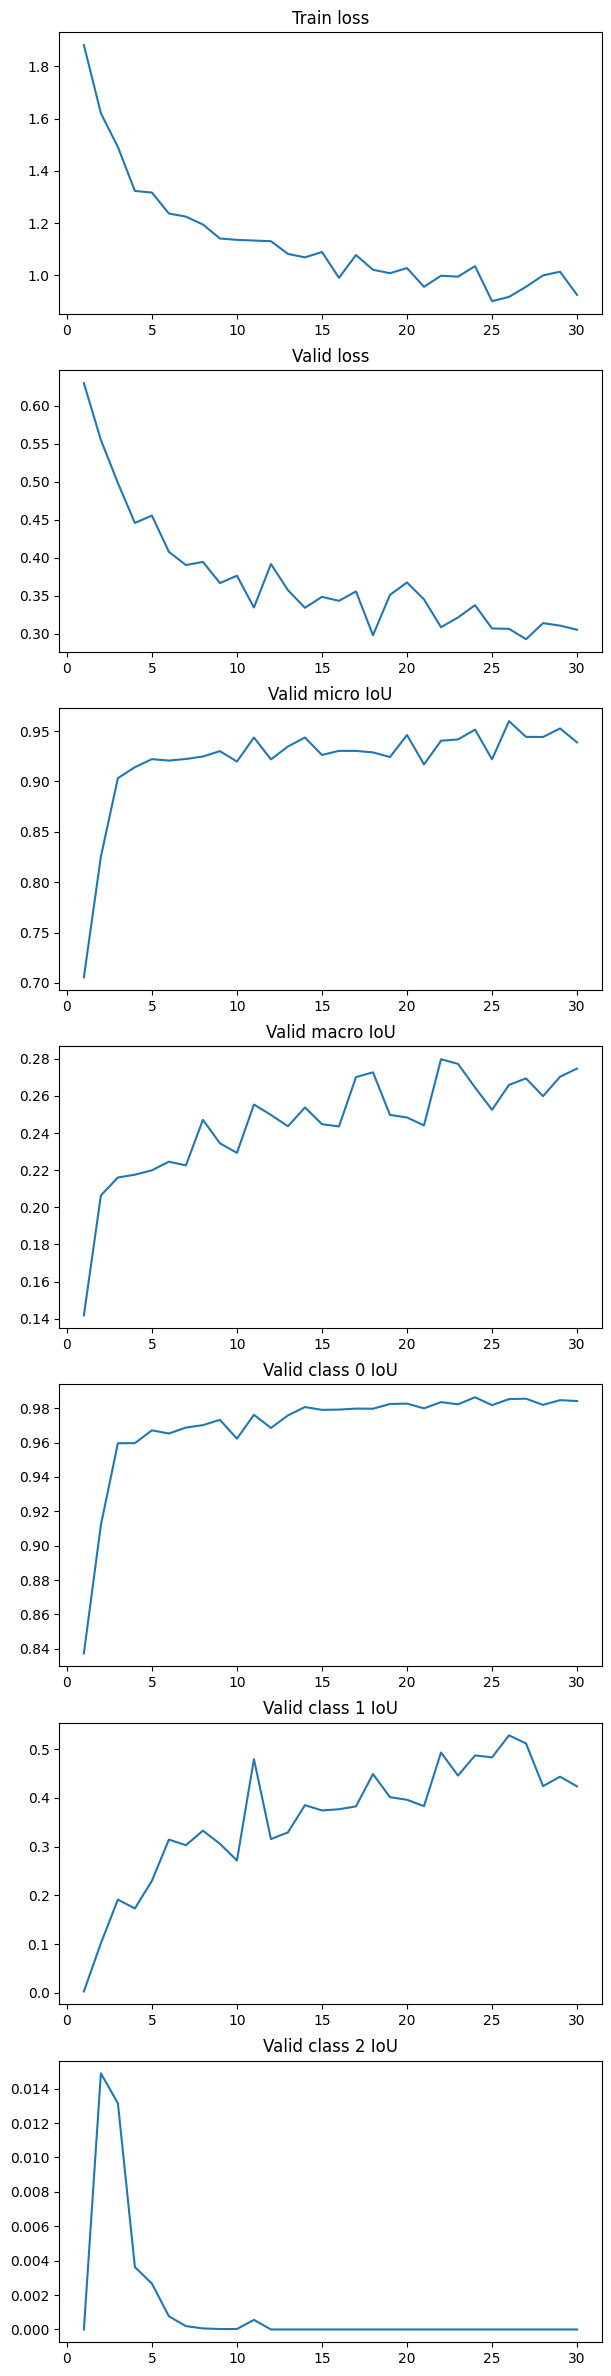

In [33]:
learner.plot_learning_info()

In [ ]:
# model.load_state_dict(torch.load('/content/drive/MyDrive/pore segmentation/manet.pkl', map_location=device))

<All keys matched successfully>

In [46]:
learner.validate_n_epochs(5)

100%|██████████| 18/18 [00:27<00:00,  1.50s/it]


{'loss': 0.134377,
 'iou_micro': 0.941158,
 'iou_macro': 0.312701,
 'iou_classes_0': 0.970281,
 'iou_classes_1': 0.542206,
 'iou_classes_2': 0.231536}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781573745100777..2.6399999999999997].


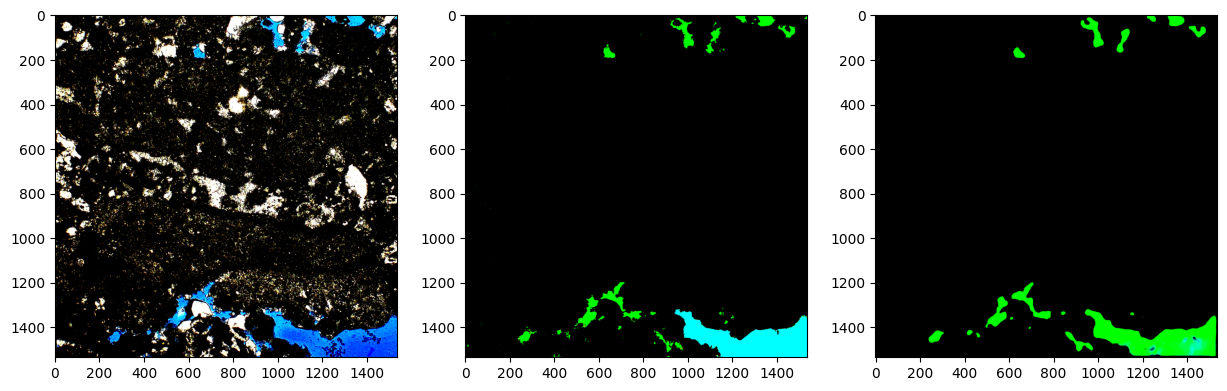

In [34]:
preds = model(xb.to(device).float())[0]
idx = 0
img = xb[idx].permute(1, 2, 0).cpu().numpy()
mask = yb[idx].cpu().numpy()
pred_mask = preds.argmax(axis=1)[idx].cpu().numpy()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(img);
axs[1].imshow(get_image_mask(mask));
axs[2].imshow(get_image_mask(pred_mask));

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..2.6399999999999997].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..2.6399999999999997].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..2.6399999999999997].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..2.6399999999999997].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..2.6399999999999997].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665296676312472..2.6399999999999997].
Clipping input data to

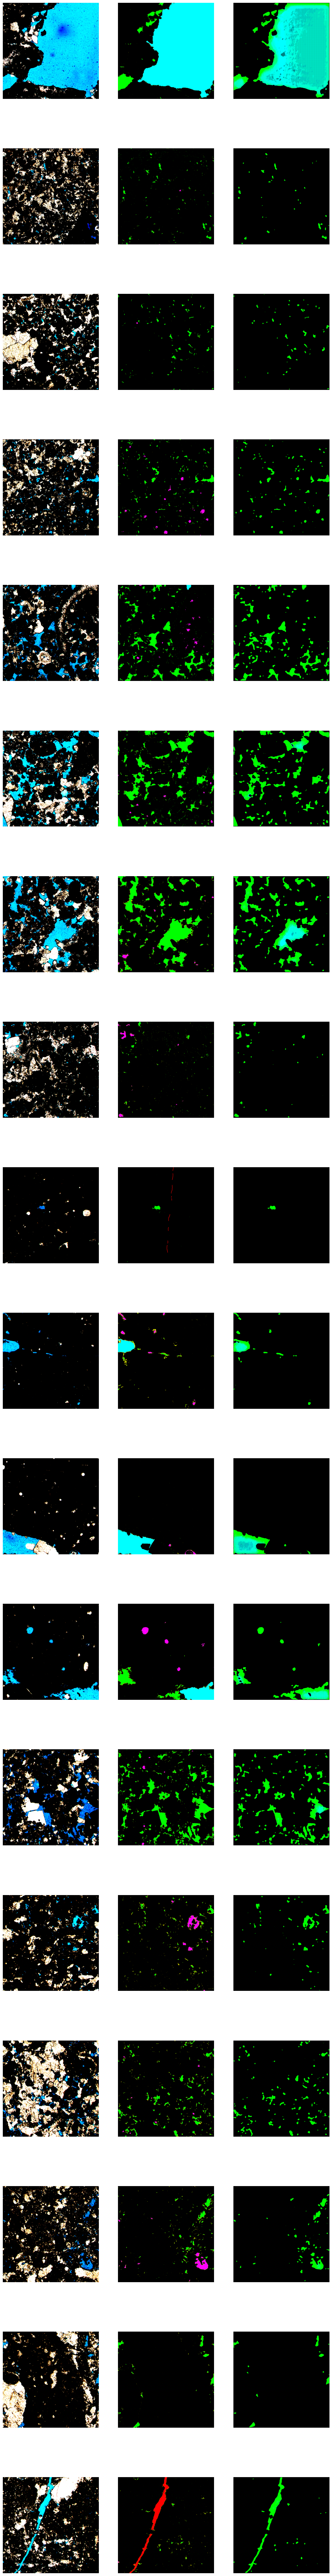

In [35]:
N = len(valid_datasets)
fig, axs = plt.subplots(N, 3, figsize=(15, 120))

for i, (x, y) in enumerate(valid_datasets):
    preds = model(torch.unsqueeze(x.to(device).float(), 0))[0]
    img = x.permute(1, 2, 0).cpu().numpy()
    mask = y.cpu().numpy()
    pred_mask = preds.argmax(axis=1).cpu().numpy()

    axs[i, 0].imshow(img);
    axs[i, 0].axis(False)
    axs[i, 1].imshow(get_image_mask(mask));
    axs[i, 1].axis(False)
    axs[i, 2].imshow(get_image_mask(pred_mask[0]));
    axs[i, 2].axis(False)
    if i == N - 1:
        break